In [2]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
from scipy.spatial import Voronoi, cKDTree
import matplotlib.pyplot as plt
from imageio.v3 import imread

cmap = plt.cm.binary

import config
from graph_models import FullGraphModel
from data_processing import DataProcessor
from train_funcs import get_activation_from_cell_type, assign_cell_type
from model_inspection_utils import process_image, process_and_plot_data

device = torch.device("cpu")
dtype = torch.float32

In [3]:
data_processor = DataProcessor(config)
model = FullGraphModel(data_processor, config).to(device)


Loading neurons from: new_data/classification.csv
Initial neurons count: 139255
Initial unique cell types: 5635
After cell type filtering: 100905 (removed 38350)
Removed cell types: ['T2a', 'Tm3', 'T4c', 'T3', 'T4d', 'Tm1', 'T5c', 'Tm2', 'T5b', 'T4b', 'Tm9', 'Tm4', 'Tm20', 'T5a', 'T5d', 'T4a', 'T2', 'T1', 'Tm6', 'TmY18', 'TmY5a', 'Tm5Y', 'TmY3', 'TmY9', 'Tm12', 'Tm5c', 'Tm5a', 'TmY4', 'TmY11', 'TmY14', 'Tm16', 'TmYem1', 'TmY20', 'Tm8', 'TmY15', 'TmY16', 'Tlp1', 'Tlp4', 'TPMN', 'Tlp6']

Analyzing boundary cases:

Loading connections from: new_data/connections_refined.csv
Raw connections loaded: 15091983
After grouping connections: 15091983
After sorting: 15091983
Neurons in pre but not in filtered set: 38330
Neurons in post but not in filtered set: 38350

Top 5 cell types of missing pre neurons:
cell_type
T2a    1781
Tm3    1746
T4c    1692
T3     1615
T4d    1578
Name: count, dtype: int64

Connections involving boundary neurons: 5253072
With non-zero syn_count: 5245004

Loading connec

In [5]:
def analyze_connections(connections, filtered_neurons):
    both_filtered = connections[
        connections["pre_root_id"].isin(filtered_neurons)
        & connections["post_root_id"].isin(filtered_neurons)
    ]

    one_filtered = connections[
        (
            connections["pre_root_id"].isin(filtered_neurons)
            ^ connections["post_root_id"].isin(filtered_neurons)
        )
    ]

    none_filtered = connections[
        ~connections["pre_root_id"].isin(filtered_neurons)
        & ~connections["post_root_id"].isin(filtered_neurons)
    ]

    print("\nConnection Analysis:")
    print(f"Both neurons filtered: {len(both_filtered)}")
    print(f"One neuron filtered: {len(one_filtered)}")
    print(f"No neurons filtered: {len(none_filtered)}")

    return both_filtered, one_filtered, none_filtered

original_neurons = data_processor._get_neurons(new_connectome=True)
filtered_celltypes = config.filtered_celltypes
connections = data_processor._get_connections(new_connectome=True)


# Use it like this
filtered_neurons = set(
    original_neurons[original_neurons["cell_type"].isin(filtered_celltypes)]["root_id"]
)
both, one, none = analyze_connections(connections, filtered_neurons)


Loading neurons from: new_data/classification.csv
Initial neurons count: 139255
Initial unique cell types: 5635

Analyzing boundary cases:

Loading connections from: new_data/connections_refined.csv
Raw connections loaded: 15091983
After grouping connections: 15091983
After sorting: 15091983
Neurons in pre but not in filtered set: 0
Neurons in post but not in filtered set: 0

Top 5 cell types of missing pre neurons:
Series([], Name: count, dtype: int64)

Connections involving boundary neurons: 0
With non-zero syn_count: 0

Loading connections from: new_data/connections.csv
Raw connections loaded: 16847997
After grouping connections: 15091983
After sorting: 15091983

Connection Analysis:
Both neurons filtered: 1120568
One neuron filtered: 4132504
No neurons filtered: 9838911


In [3]:
checkpoint = torch.load("models/m_2024-12-27_10:44_d0ejaj1i.pth", map_location="cpu")
if "root_ids" in checkpoint:
    print("\nCheckpoint has root_ids information")
# You might also want to check other keys that could contain this info
print("All checkpoint keys:", list(checkpoint.keys()))
if "model" in checkpoint:
    print("Model state dict keys:", list(checkpoint["model"].keys()))

All checkpoint keys: ['model', 'optimizer']
Model state dict keys: ['decision_making_vector', 'connectome.edge_weight_multiplier', 'connectome.edge_weight', 'final_fc.weight', 'final_fc.bias']


/tmp/ipykernel_139351/2372807154.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/m_2024-12-27_10:44_d0ejaj1i.pth", map_location="cpu")


In [4]:
checkpoint = torch.load("models/m_2024-12-27_10:44_d0ejaj1i.pth", map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.eval()
connections = (
    pd.read_csv(
        "new_data/connections.csv",
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    .groupby(["pre_root_id", "post_root_id"])
    .sum("syn_count")
    .reset_index()
)

connections["weight"] = model.connectome.edge_weight_multiplier.detach()
right_root_ids = data_processor.right_root_ids
all_neurons = (
    pd.read_csv("new_data/classification.csv")
    .merge(right_root_ids, on="root_id")
    .fillna("Unknown")
)
right_visual_neurons = data_processor.voronoi_cells.get_tesselated_neurons().merge(
    right_root_ids, on="root_id"
)
neuron_data = pd.read_csv(
    "new_data/right_visual_positions_selected_neurons.csv",
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])
data_cols = ["x_axis", "y_axis"]
decision_making_vector = data_processor.decision_making_vector
all_coords = pd.read_csv("adult_data/all_coords_clean.csv", dtype={"root_id": "string"})
rational_cell_types = pd.read_csv("adult_data/rational_cell_types.csv")

/tmp/ipykernel_182434/3740955720.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("models/m_2024-12-27_10:44_d0ejaj1i.pth", map_location="cpu")


RuntimeError: Error(s) in loading state_dict for FullGraphModel:
	size mismatch for connectome.edge_weight_multiplier: copying a param with shape torch.Size([9798690]) from checkpoint, the shape in current model is torch.Size([9768460]).
	size mismatch for connectome.edge_weight: copying a param with shape torch.Size([9798690]) from checkpoint, the shape in current model is torch.Size([9768460]).

In [5]:
# tesselation propagation
centers = neuron_data[neuron_data["cell_type"] == "R7"][data_cols].values
voronoi = Voronoi(centers)
tree = cKDTree(centers)
neuron_indices = tree.query(neuron_data[data_cols].values)[1]
neuron_data["voronoi_indices"] = neuron_indices

In [6]:
img = imread("images/five_to_fifteen/train/yellow/img_12_8_174_equalized_.png")
processed_image = process_image(img, tree)
neuron_data = neuron_data.merge(processed_image, left_on="voronoi_indices", right_index=True)
neuron_data["cell_type"] = neuron_data.apply(assign_cell_type, axis=1)
neuron_data["activation"] = neuron_data.apply(get_activation_from_cell_type, axis=1)

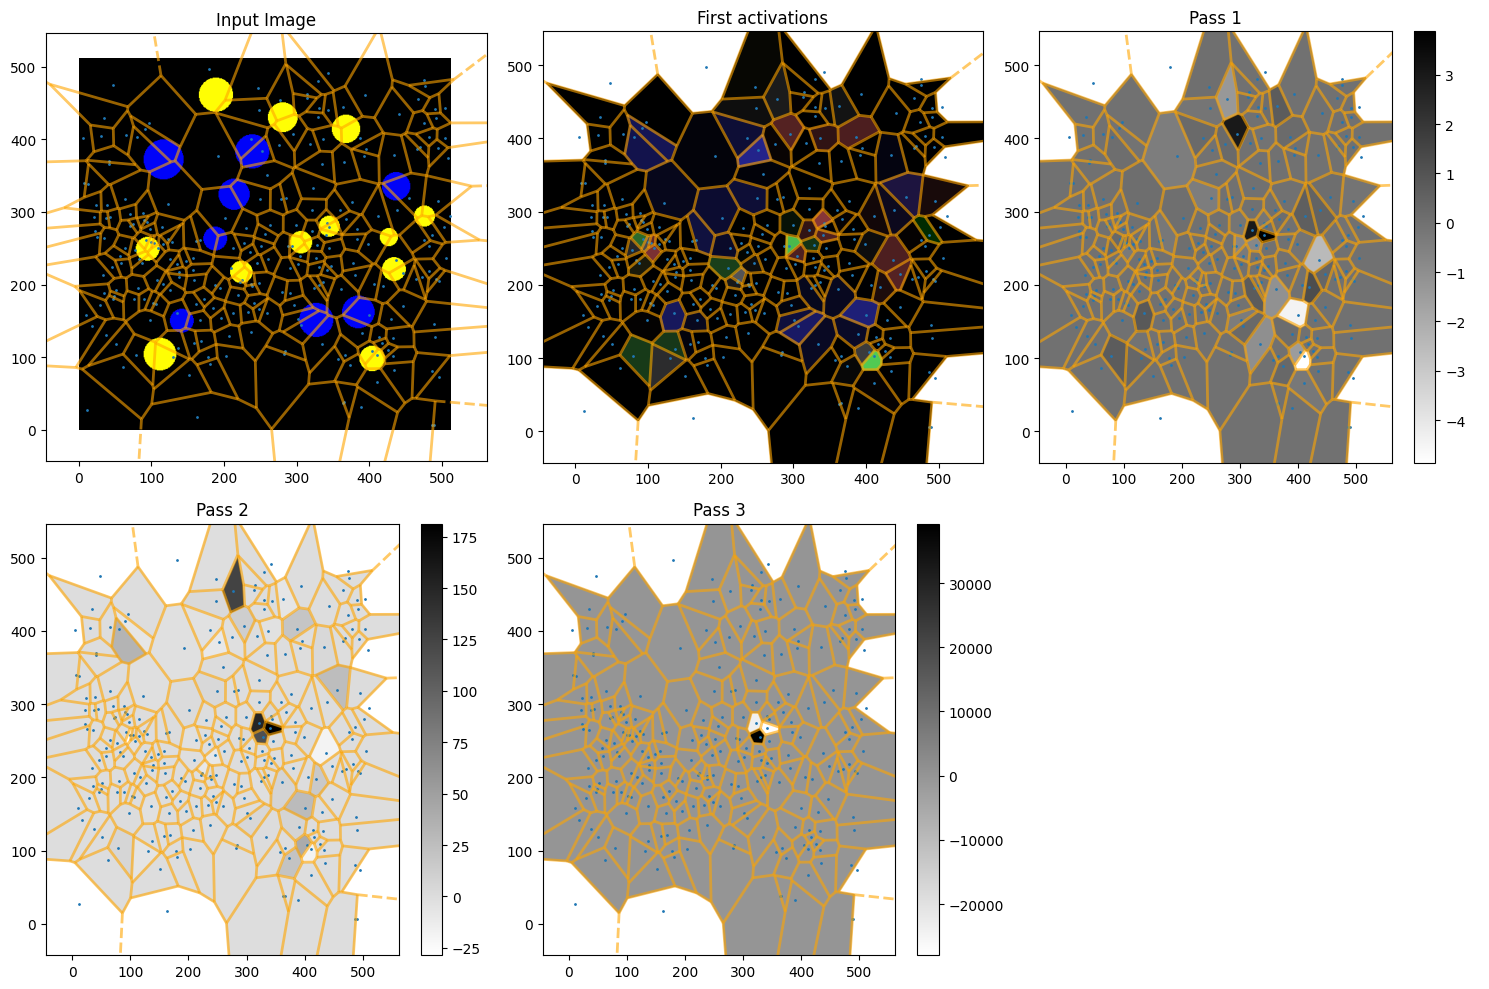

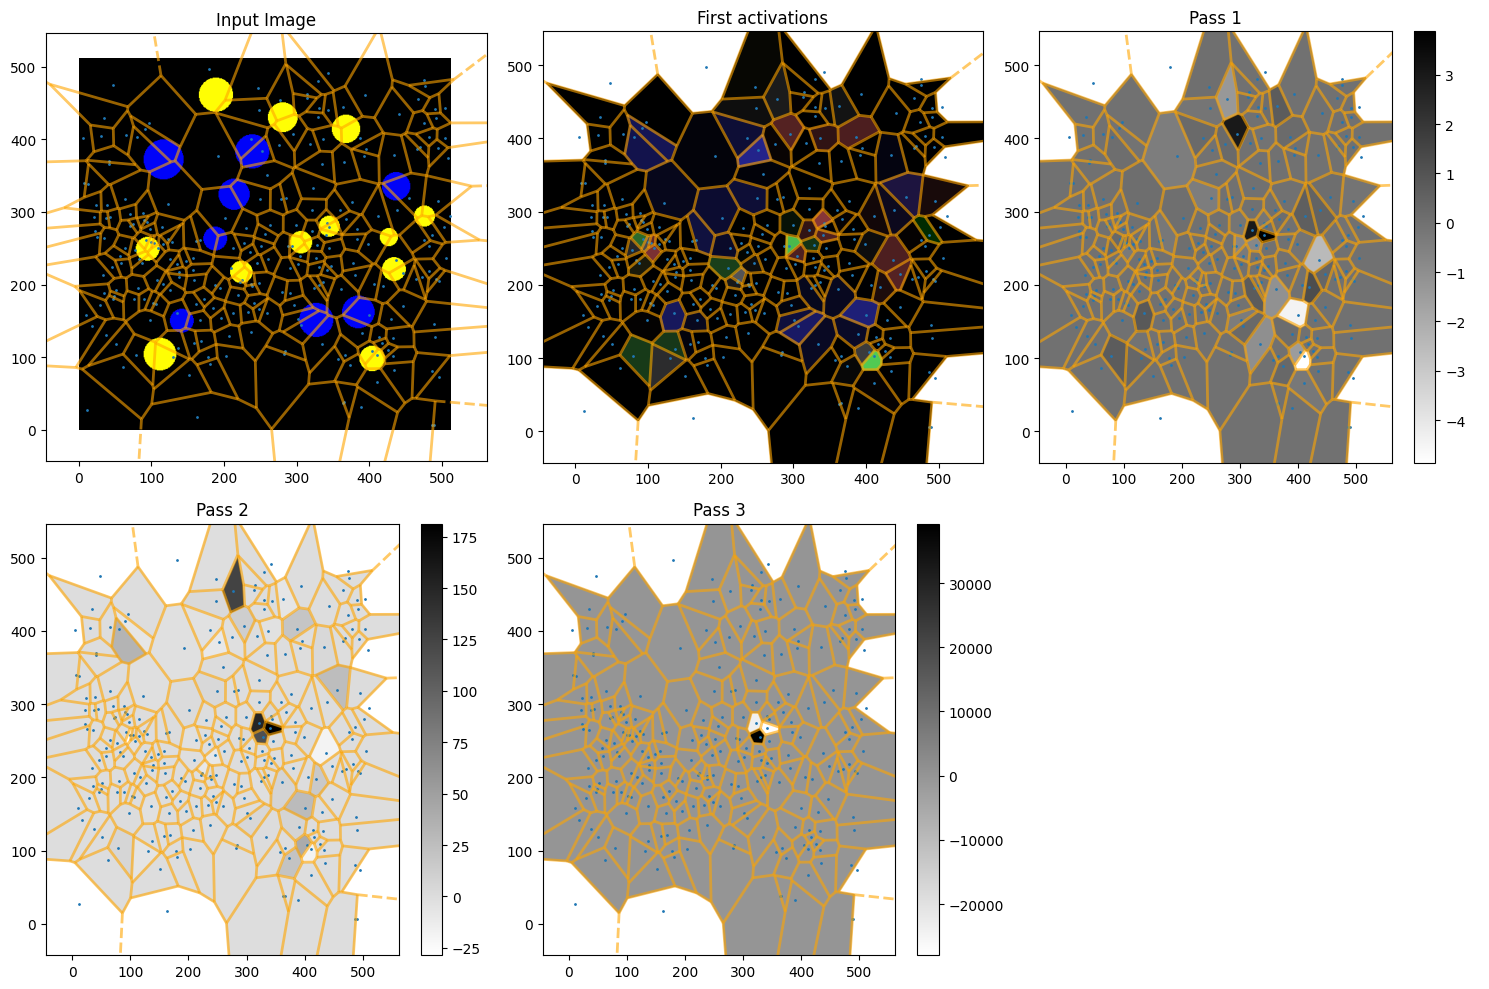

In [8]:
%matplotlib inline
tplot = process_and_plot_data(img, neuron_data, connections, voronoi, 3)

In [6]:
data_processor = CompleteModelsDataProcessor(config)

# Print key information about the synaptic matrix
print(f"Synaptic matrix shape: {data_processor.synaptic_matrix.shape}")
print(f"Number of non-zero elements: {data_processor.synaptic_matrix.nnz}")
print(f"First 5 row indices: {data_processor.synaptic_matrix.row[:5]}")
print(f"First 5 col indices: {data_processor.synaptic_matrix.col[:5]}")
print(f"First 5 data values: {data_processor.synaptic_matrix.data[:5]}")

# Print information about the root IDs
print(f"Number of root IDs: {len(data_processor.root_ids)}")
print(f"First 5 root IDs: {data_processor.root_ids['root_id'].iloc[:5]}")

# Print edge information from the model
print(f"Edge index shape: {data_processor.edges.shape}")
print(f"Edge weights shape: {data_processor.weights.shape}")

print("Configuration check:")
print(f"filtered_celltypes: {config.filtered_celltypes}")
print(f"neurons: {config.neurons}")
print(f"voronoi_criteria: {config.voronoi_criteria}")
print(f"new_connectome: {config.new_connectome}")
print(f"refined_synaptic_data: {config.refined_synaptic_data}")
print(f"eye: {config.eye}")
print(f"rational_cell_types: {config.rational_cell_types}")

Synaptic matrix shape: (130785, 130785)
Number of non-zero elements: 13865621
First 5 row indices: [0 0 0 0 0]
First 5 col indices: [ 31  41  74 319 484]
First 5 data values: [1 3 8 2 2]
Number of root IDs: 130785
First 5 root IDs: 0    720575940628857210
1    720575940626838909
2    720575940626046919
3    720575940630311383
4    720575940633370649
Name: root_id, dtype: string
Edge index shape: torch.Size([2, 13865621])
Edge weights shape: torch.Size([13865621])
Configuration check:
filtered_celltypes: ['Mi1', 'Mi9', 'Mi4', 'Mi15', 'Mi2', 'Mi13', 'Mi10', 'Mi14']
neurons: all
voronoi_criteria: R7
new_connectome: True
refined_synaptic_data: False
eye: right
rational_cell_types: ['KCapbp-m', 'KCapbp-ap2', 'KCapbp-ap1']


In [6]:
def validate_synaptic_matrix(matrix, previous_state=None):
    """
    Validates a synaptic matrix for consistency and returns key metrics for comparison.
    
    Args:
        matrix: The sparse matrix to validate 
        previous_state: Optional dict with previous metrics to compare against
    
    Returns:
        dict: Metrics about the matrix
    """
    # Get key metrics
    metrics = {
        "shape": matrix.shape,
        "nnz": matrix.nnz,
        "min_weight": float(matrix.data.min()),
        "max_weight": float(matrix.data.max()),
        "mean_weight": float(matrix.data.mean()),
        "zero_values": int((np.abs(matrix.data) < 1e-10).sum()),
        "unique_values": len(np.unique(matrix.data))
    }
    
    # Compare with previous if provided
    if previous_state:
        differences = []
        for key in metrics:
            if metrics[key] != previous_state[key]:
                differences.append(f"{key}: {previous_state[key]} -> {metrics[key]}")
        
        if differences:
            print("WARNING: Matrix metrics changed:")
            for diff in differences:
                print(f"  {diff}")
        else:
            print("Matrix metrics consistent with previous state")
            
    return metrics

# Usage example:
state = None
def check_matrix_consistency():
    global state
    
    # Create processor and get matrix
    data_processor = DataProcessor(config)
    
    # Validate matrix
    new_state = validate_synaptic_matrix(data_processor.synaptic_matrix, state)
    
    # Store for next comparison
    state = new_state
    
    return data_processor

In [7]:
# First run
processor1 = check_matrix_consistency()

# Second run
processor2 = check_matrix_consistency()  # Should show "Matrix metrics consistent"


Loading neurons from: new_data/classification.csv
Initial neurons count: 139255
Initial unique cell types: 5635
After cell type filtering: 100905 (removed 38350)
Removed cell types: ['T2a', 'Tm3', 'T4c', 'T3', 'T4d', 'Tm1', 'T5c', 'Tm2', 'T5b', 'T4b', 'Tm9', 'Tm4', 'Tm20', 'T5a', 'T5d', 'T4a', 'T2', 'T1', 'Tm6', 'TmY18', 'TmY5a', 'Tm5Y', 'TmY3', 'TmY9', 'Tm12', 'Tm5c', 'Tm5a', 'TmY4', 'TmY11', 'TmY14', 'Tm16', 'TmYem1', 'TmY20', 'Tm8', 'TmY15', 'TmY16', 'Tlp1', 'Tlp4', 'TPMN', 'Tlp6']

Analyzing boundary cases:

Loading connections from: new_data/connections_refined.csv
Raw connections loaded: 15091983
After grouping connections: 15091983
After sorting: 15091983
Neurons in pre but not in filtered set: 38330
Neurons in post but not in filtered set: 38350

Top 5 cell types of missing pre neurons:
cell_type
T2a    1781
Tm3    1746
T4c    1692
T3     1615
T4d    1578
Name: count, dtype: int64

Connections involving boundary neurons: 5253072
With non-zero syn_count: 5245004

Loading connec